In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ..

/media/xwan/HDD2/Projects/postNAS


In [3]:
import pickle
import numpy as np
l = pickle.load(open('data/nb301_top_arch_info_with_importance.pickle', 'rb'))

In [4]:
from search_spaces.nas301 import NASBench301

Importing NAS-Bench-301 API failed


In [5]:
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
from networkx.drawing.nx_pydot import graphviz_layout
import numpy as np
import seaborn as sns
from tqdm import tqdm
import pandas as pd

In [6]:
import pickle

In [7]:
shorthand = {
    'sep_conv_3x3': 's3',
    'sep_conv_5x5': 's5',
    'dil_conv_3x3': 'd3',
    'dil_conv_5x5': 'd5',
    'skip_connect': 'skip',
    'max_pool_3x3': 'mp3',
    'avg_pool_3x3': 'ap3',
    '': '',
}

In [18]:
def get_constrained_random_arch(same_normal_reduce=False, constrain_primitives=True, ):
    """Get a randomly sampled architecutre in the DARTS search space subjected to some Skip constraint"""
    PRIMITIVES = [
    'max_pool_3x3',
    'avg_pool_3x3',
    'skip_connect',
    'sep_conv_3x3',
    'sep_conv_5x5',
    'dil_conv_3x3',
    'dil_conv_5x5'
    ]
    
    if constrain_primitives:
        MODIFIED_PRIMITIVES = [
            'sep_conv_3x3',
            'sep_conv_5x5',
        ]
    else:
         MODIFIED_PRIMITIVES = PRIMITIVES

    def _constrained_sample_cell():
        wiring = [0, 1]
        for order in range(2, 5):   # random sampling from the node 1
            xrange = np.arange(order)
            chosen_nodes = np.random.choice(xrange, 2, replace=False).tolist()
            wiring += chosen_nodes
        assert len(wiring) == 8, wiring
        # now fix the operation. Note the first node wiring is fixed a-priori
        spec = [('skip_connect', 0), ('skip_connect', 1)]
        for i in range(2, 8):
            current_node = wiring[i]
            op_choice = np.random.choice(MODIFIED_PRIMITIVES) if constrain_primitives else np.random.choice(PRIMITIVES)
            spec.append((op_choice, current_node))
        return spec
    
    normal_spec = _constrained_sample_cell()
    if same_normal_reduce:
        reduce_spec = deepcopy(normal_spec)
    else:
        reduce_spec = _constrained_sample_cell()
    genotype = Genotype(normal=normal_spec, normal_concat=[2,3,4,5], reduce=reduce_spec, reduce_concat=[2,3,4,5])
    return genotype

In [9]:
def get_random_arch( same_normal_reduce=True, constrain_primitive=True):
    """
    n: number of random samples to yield
    same_arch (bool): whether to use the same architecture for the normal cell and the reduction cell
    """

    """Generate a list of 2 tuples, consisting of the random DARTS Genotype and DiGraph"""
    if constrain_primitive:
        PRIMITIVES = [
        'skip_connect',
        'sep_conv_3x3',
        'sep_conv_5x5',]
    else:
        PRIMITIVES = [
        'max_pool_3x3',
        'avg_pool_3x3',
        'skip_connect',
        'sep_conv_3x3',
        'sep_conv_5x5',
        'dil_conv_3x3',
        'dil_conv_5x5'
        ]
    N_TOWERS = 4

    def _sample():
        normal = []
        reduction = []
        for i in range(N_TOWERS):
            ops = np.random.choice(range(len(PRIMITIVES)), N_TOWERS)

            # input nodes for conv
            nodes_in_normal = np.random.choice(range(i + 2), 2, replace=False)
            # input nodes for reduce
            if same_normal_reduce:
                nodes_in_reduce = nodes_in_normal
                normal.extend([(PRIMITIVES[ops[0]], nodes_in_normal[0]), (PRIMITIVES[ops[1]], nodes_in_normal[1])])
                reduction.extend(
                    [(PRIMITIVES[ops[0]], nodes_in_reduce[0],), (PRIMITIVES[ops[1]], nodes_in_reduce[1])])
            else:
                op_in_reduce = np.random.choice(range(len(PRIMITIVES)), N_TOWERS)
                nodes_in_reduce = np.random.choice(range(i + 2), 2, replace=False)
                normal.extend([(PRIMITIVES[ops[0]], nodes_in_normal[0]), (PRIMITIVES[ops[1]], nodes_in_normal[1])])
                reduction.extend(
                    [(PRIMITIVES[op_in_reduce[0]], nodes_in_reduce[0],),
                     (PRIMITIVES[op_in_reduce[1]], nodes_in_reduce[1])])

        darts_genotype = Genotype(normal=normal, normal_concat=range(2, 2 + N_TOWERS),
                                  reduce=reduction, reduce_concat=range(2, 2 + N_TOWERS))
        return darts_genotype

    # obtain a randomly sampled genotype
    genotype = _sample()
    return genotype

In [10]:
from collections import namedtuple
Genotype = namedtuple('Genotype', 'normal normal_concat reduce reduce_concat')
from copy import deepcopy
import pickle

In [11]:
from search_spaces.nas301 import Genotype

In [12]:
from darts_cnn.visualize import plot

In [13]:
ss = NASBench301(file_path='/media/xwan/HDD2/NASDatasets/nasbench301_models_v0.9/nb_models',)

Loading NB301 failed. API-less mode. Error message is name 'nb' is not defined


In [15]:
ss.log_scale = False
ss.negative = False

In [17]:
# Random
random_archs = [ss.get_random_arch(same_normal_reduce=False, return_string=False) for _ in range(100)]
random_arch_perfs = [ss.query(s, with_noise=False) for s in random_archs]

In [18]:
# Prim Constraint
random_archs_primitive_constrained = [get_random_arch(same_normal_reduce=False, constrain_primitive=True) for _ in range(100)]
random_archs_primitive_constrained_perfs = [ss.query(s, with_noise=False) for s in random_archs_primitive_constrained]

In [19]:
# PrimSkip Constraints
constrained_random_archs = [get_constrained_random_arch(same_normal_reduce=False, constrain_primitives=True) for _ in range(100)]
constrained_arch_perfs = [ss.query(s, with_noise=False) for s in constrained_random_archs2]

In [20]:
# Skip Constraints 
no_primitive_constraint = [get_constrained_random_arch(same_normal_reduce=False, constrain_primitives=False) for _ in range(100)]
no_primitive_constraint_perfs = [ss.query(s, with_noise=False) for s in no_primitive_constraint]

In [22]:
import matplotlib
matplotlib.rcParams.update({'font.size': 16.5})

In [24]:
all_res = pd.DataFrame(np.nan, columns=['Random', 'Skip','Prim',  'PrimSkip', ], index=np.arange(100))
all_res.iloc[:, 0] = random_arch_perfs
all_res.iloc[:, 1] = no_primitive_constraint_perfs
all_res.iloc[:, 2] = random_archs_primitive_constrained_perfs
all_res.iloc[:, 3] = constrained_arch_perfs
# all_res.iloc[:, 4] = constrained_arch_perfs2
all_res = all_res * 100

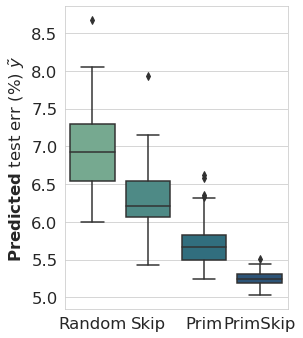

In [25]:
plt.figure(figsize=[4.5, 5])
sns.boxplot(data=all_res, palette="crest")
plt.ylabel('$\mathbf{Predicted}$ test err (%) $\\tilde{y}$')
plt.savefig('./figs/sample_n301_pred.pdf', dpi=200, bbox_inches='tight')